In [1]:
import numpy as np
import mne
import matplotlib
%matplotlib inline
#%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import glob, os
import scipy
import pickle
import networkx as nx
import preprocessing as prep
from itertools import permutations
import pandas as pd
from tqdm import tqdm

from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import fdrcorrection

from epoch_connectivity import ConnEEG as cnegg
from epoch_connectivity import ConnectionMatrices as cm
from epoch_connectivity import Connectomes as cntms

from epoch_connectivity.utils import FrequencyBand, only_EEG_channels

import mne_connectivity as mnecon

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

In [3]:
def get_column_name(measure_used, record_status, frequency_band, graph_measure=None):
    if measure_used is not 'wPLI':
        return measure_used+'_'+frequency_band+'_'+record_status+'_'+graph_measure
    else:
        return measure_used+'_'+frequency_band+'_'+record_status+'_'+'MEAN_SYNCH'
    
    
def r_nr_asarrays(column_name, full_dataframe):
    responders = np.array(full_dataframe.loc[full_dataframe["response"] == "R", column_name])
    non_responders = np.array(full_dataframe.loc[full_dataframe["response"] == "NR", column_name])
    return responders, non_responders

def count_fp_tp(y_true, y_pred):
    fp, tp = 0, 0
    for i in range(len(y_true)):
        if y_pred[i] == 1 and y_true[i] == 1:
            tp += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            fp += 1
    return fp, tp

def get_prediction(X, y, threshold, paat):
    y_pred = []
    for x in X:
        if paat:
            if x > threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        else:
            if x < threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
    return np.array(y_pred)

def get_fp_tp(X, y, threshold, paat):
    y_pred = get_prediction(X, y, threshold, paat)
    fp, tp = count_fp_tp(y, y_pred)
    correct_predictions = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            correct_predictions += 1
    return fp, tp, correct_predictions

def get_reduced_df(full_dataframe, measure_used, record_status, graph_measure=None):
    columns_to_get = []
    for frequency_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
        columns_to_get.append(get_column_name(measure_used=measure_used, graph_measure=graph_measure,
                                              record_status=record_status, frequency_band=frequency_band))
    columns_to_get.append('response')
    return full_dataframe[columns_to_get]

def get_plot_title(measure_used, record_status, graph_measure=None):
    g_measure_name = {'GE':'Global efficiency', 'MOD':'Modularity', 'GRC':'Global reaching centrality',
                      'DA':'Degree assortativity', 'AVGCC':'Average clustering coefficient', 'MEAN_SYNCH':'Mean synchronization'}
    rec_status_name = {'SLEEP':'asleep', 'AWAKE':'awake'}
    if measure_used is not 'wPLI':
        if record_status=='ASRATIO':
            return f'{g_measure_name[graph_measure]} ratio between awake and asleep EEG', f'{g_measure_name[graph_measure]} awake / {g_measure_name[graph_measure]} asleep'
        else:
            return g_measure_name[graph_measure]+' ('+measure_used+') while '+rec_status_name[record_status], g_measure_name[graph_measure]+' value'
    else:
        if record_status=='ASRATIO':
            return f'wPLI mean synchronization ratio between awake and asleep EEG', 'Mean wPLI awake / Mean wPLI asleep'
        else:
            return 'wPLI mean synchronization while '+rec_status_name[record_status], 'Mean wPLI value'
    
def plot_boxplot(full_dataframe, measure_used, record_status, directory_to_save=None, graph_measure=None, savefig=False):
    reduced_df = get_reduced_df(full_dataframe=full_dataframe, measure_used=measure_used, graph_measure=graph_measure,
                                record_status=record_status)
    my_pal = {"R": "#0298AF", "NR": "#D11D18"}
    bp = sns.boxplot(x="variable", y="value", hue="response", data=pd.melt(reduced_df, id_vars='response'),
                     linewidth=0.8, palette=my_pal, fliersize=1.5)
    bp.set_xticklabels(['delta', 'theta', 'alpha', 'beta', 'broadband'])
    title, y_label = get_plot_title(measure_used=measure_used, record_status=record_status, graph_measure=graph_measure)
    plt.xlabel('Frequency bands')
    plt.ylabel(y_label)
    plt.title(title)
    if savefig:
        plt.savefig(directory_to_save)
        plt.close()
    return

def plot_conf_mantrix(X, y, threshold, paat, best_threshold_string, directory_to_save, measure_used,
                      record_status, frequency_band, graph_measure=None):
    
    def CM_title(measure_used, record_status, frequency_band, best_threshold_string, graph_measure=None):
        g_measure_name = {'GE':'GE', 'MOD':'Modularity', 'GRC':'GRC',
                      'DA':'DA', 'AVGCC':'Avg. CC', 'MEAN_SYNCH':'Mean synch.'}
        rec_status_name = {'SLEEP':'asleep', 'AWAKE':'awake'}
        if measure_used is not 'wPLI':
            if record_status=='ASRATIO':
                return f'CM for {g_measure_name[graph_measure]} {best_threshold_string} awake/asleep on {frequency_band} band'
            else:
                return f'CM for {g_measure_name[graph_measure]} {best_threshold_string} ({measure_used}) while {rec_status_name[record_status]} on {frequency_band} band'
        else:
            if record_status=='ASRATIO':
                return f'CM for wPLI mean synch. awake/asleep {best_threshold_string} on {frequency_band} band'
            else:
                return f'CM for wPLI mean synch. {best_threshold_string} while {rec_status_name[record_status]} on {frequency_band} band'
    
    y_pred = get_prediction(X=X, y=y, threshold=threshold, paat=paat)
    
    conf_matrix = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    ax.xaxis.tick_bottom()
    xaxis = np.arange(2)
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(['NR', 'R'])
    ax.set_yticklabels(['NR', 'R'])
    ax.grid(False)
    plt.xlabel('Predictions', fontsize=15)
    plt.ylabel('Actuals', fontsize=15)
    plt.title(CM_title(measure_used, record_status, frequency_band, best_threshold_string, graph_measure))
    plt.savefig(f'{directory_to_save}_confmatrix.pdf', format='pdf')
    plt.close()
    return

def plot_ROC(full_dataframe, measure_used, record_status, frequency_band, directory_to_save=None, graph_measure=None, savefig=False, save_conf_matrix=False):
    
    def ROC_title(measure_used, record_status, frequency_band, graph_measure):
        g_measure_name = {'GE':'Global efficiency', 'MOD':'Modularity', 'GRC':'Global reaching centrality',
                      'DA':'Degree assortativity', 'AVGCC':'Average clustering coefficient', 'MEAN_SYNCH':'Mean synchronization'}
        rec_status_name = {'SLEEP':'asleep', 'AWAKE':'awake'}
        if measure_used is not 'wPLI':
            if record_status=='ASRATIO':
                return f'ROC for {g_measure_name[graph_measure]} awake/asleep on {frequency_band} band'
            else:
                return f'ROC for {g_measure_name[graph_measure]} ({measure_used}) while {rec_status_name[record_status]} on {frequency_band} band'
        else:
            if record_status=='ASRATIO':
                return f'ROC for wPLI mean synch. awake/asleep on {frequency_band} band'
            else:
                return f'ROC for wPLI mean synch. while {rec_status_name[record_status]} on {frequency_band} band'
    
    column_name = get_column_name(measure_used=measure_used, record_status=record_status, frequency_band=frequency_band, graph_measure=graph_measure)
    X, y = full_df[column_name].copy(), full_df['response'].copy()
    y.replace(to_replace='NR', value=0, inplace=True)
    y.replace(to_replace='R', value=1, inplace=True)
    X, y = np.array(X), np.array(y)
    
    r, nr = r_nr_asarrays(column_name=column_name, full_dataframe=full_dataframe)
    #rnrratio = np.mean(r)/np.mean(nr)
    
    if np.mean(r) > np.mean(nr):
        positive_are_above_threshold = True
    else:
        positive_are_above_threshold = False
    
    #min_thresh, max_thresh = X.min(), X.max()
    thresholds = np.sort(X)
    thresholds = np.append(thresholds, np.inf)
    thresholds = np.insert(thresholds, 0, -np.inf)
    #defining fpr and tpr
    tpr, fpr, correct = [], [], []
    # defining positives and negatives
    positives, negatives = np.sum(y==1), np.sum(y==0)

    # looping over threshold scores and getting the number of false positives and true positives
    for th in thresholds:
        fp,tp, correct_predictions = get_fp_tp(X, y, th, positive_are_above_threshold)
        tpr.append(tp/positives)
        fpr.append(fp/negatives)
        correct.append(correct_predictions)
    fpr, tpr, correct = np.array(fpr), np.array(tpr), np.array(correct)

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label="ROC curve (area = %0.2f)" % roc_auc, color="blue", lw=1)

    fpr, tpr = np.array(fpr), np.array(tpr)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)

    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best (threshold = %0.2f)' % thresholds[ix])
    plt.plot([0, 1], [0, 1], color="red", lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(ROC_title(measure_used=measure_used, record_status=record_status, frequency_band=frequency_band, graph_measure=graph_measure))
    plt.legend(loc="lower right")
    if savefig:
        plt.savefig(directory_to_save+'.pdf')
        plt.close()
    else:
        plt.show()
        
    if positive_are_above_threshold:
        best_threshold = f'> {thresholds[ix]:.2f}'
    else:
        best_threshold = f'< {thresholds[ix]:.2f}'
    
    best_threshold_sensitivity, best_threshold_specificity = tpr[ix], 1-fpr[ix]
    
    best_th_sens_ci = proportion_confint(count=int(tpr[ix]*positives), nobs=positives, method='beta')
    best_th_spec_ci = proportion_confint(count=int(negatives - fpr[ix]*negatives), nobs=negatives, method='beta')
    acc_ci = proportion_confint(count=correct[ix], nobs=len(y), method='beta')
    
    if save_conf_matrix:
        plot_conf_mantrix(X=X, y=y, threshold=thresholds[ix], paat=positive_are_above_threshold,
                          best_threshold_string=best_threshold, directory_to_save=directory_to_save,
                          measure_used=measure_used, record_status=record_status, frequency_band=frequency_band,
                          graph_measure=graph_measure)
    
    return column_name, roc_auc, best_threshold, best_threshold_sensitivity, best_th_sens_ci, best_threshold_specificity, best_th_spec_ci, correct[ix]/len(y), acc_ci



In [4]:
plot_boxplot(full_dataframe=full_df, measure_used='PDC', record_status='SLEEP', 
             graph_measure='GE', directory_to_save='asdf.pdf', savefig=True)

NameError: name 'full_df' is not defined

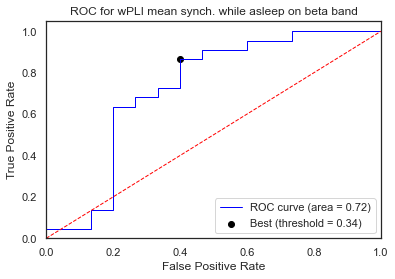

('wPLI_beta_SLEEP_MEAN_SYNCH',
 0.7242424242424244,
 '> 0.34',
 0.8636363636363636,
 (0.6508779027425918, 0.9709441488712534),
 0.6,
 (0.32286976620628166, 0.8366356761404866),
 0.7567567567567568,
 (0.588008307576086, 0.8822748256928921))

In [107]:
plot_ROC(full_dataframe=full_df, measure_used='wPLI', record_status='SLEEP', frequency_band='beta')

### Code used to test the normality of the data

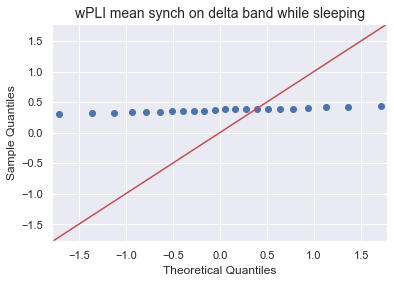

In [84]:
import numpy as np
import statsmodels.api as sm
import pylab

column = get_column_name(measure_used='wPLI', record_status='SLEEP', frequency_band='delta')#, graph_measure='GE')
a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)

#test = np.random.normal(0,1, 1000)

sm.qqplot(a, line='45')
pylab.title('wPLI mean synch on delta band while sleeping', fontsize=14)
pylab.show()

### Mann-Whitney U test and Boxplot for the networks thresholded with the surrogate data test
It is necessary to do the Mann-Whitney U test because the data is not normal, so the T-student is not a good option. Also, we test the ration between the measures between awake and asleep EEG.

In [22]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('surrogate_18042022.csv', index_col=0) # Read the features dataframe

# To create columns with the ration among the features on AWAKE/SLEEP state
#for measure in ['wPLI', 'PDC', 'DTF']:
#    if measure == 'wPLI':
#        for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
#            features[f'{measure}_{f_band}_ASRATIO_MEAN_SYNCH'] = features[f'{measure}_{f_band}_AWAKE_MEAN_SYNCH'].div(features[f'{measure}_{f_band}_SLEEP_MEAN_SYNCH'])
#    else:
#        for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
#            for graph_measures in ['GE', 'GRC', 'MOD', 'DA', 'AVGCC']:
#                features[f'{measure}_{f_band}_ASRATIO_{graph_measures}'] = features[f'{measure}_{f_band}_AWAKE_{graph_measures}'].div(features[f'{measure}_{f_band}_SLEEP_{graph_measures}'])

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = "R"
full_df.loc[full_df["response"] == "PR", "response"] = "R"

In [23]:
full_df['response'].value_counts()

R     22
NR    15
Name: response, dtype: int64

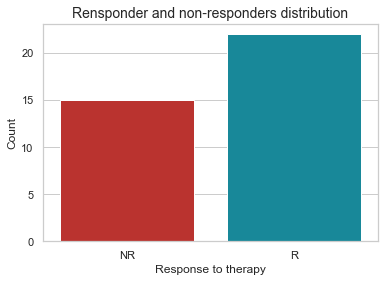

In [7]:
my_pal = {"R": "#0298AF", "NR": "#D11D18"}
sns.countplot(x="response", data=full_df, palette=my_pal)
plt.title('Rensponder and non-responders distribution', fontsize=14)
plt.xlabel('Response to therapy')
plt.ylabel('Count')
plt.savefig('responders-non-responders-count.pdf')

In [11]:
# Perform the boxplots for all the measures and the t-student test
directory = 'C:/code_thesis/brain_connectivity_epilepsy/data_analysis/surrogate/'
t_test_df = {}
t_test_df['measure'], t_test_df['delta'], t_test_df['theta'], t_test_df['alpha'], t_test_df['beta'], t_test_df['broadband'] = [], [], [], [], [], []
for measure in ['wPLI', 'PDC', 'DTF']:
    if measure == 'wPLI':
        for record_status in ['AWAKE', 'SLEEP']:
            t_test_df['measure'].append(measure+'_'+record_status+'_'+'MEAN_SYNCH')
            to_save = directory+'surrogate_'+measure+'_'+record_status+'.pdf'
            plot_boxplot(full_dataframe=full_df, measure_used=measure, record_status=record_status,
                             graph_measure=None, directory_to_save=to_save, savefig=True)
            for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
                column = get_column_name(measure_used=measure, record_status=record_status, frequency_band=f_band)
                a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)
                t_test_df[f_band].append(scipy.stats.mannwhitneyu(a, b)[1])
    else:
        for record_status in ['AWAKE', 'SLEEP']:
            for graph_measures in ['GE', 'GRC', 'MOD', 'DA', 'AVGCC']:
                t_test_df['measure'].append(measure+'_'+record_status+'_'+graph_measures)
                to_save = directory+'surrogate_'+measure+'_'+record_status+'_'+graph_measures+'.pdf'
                plot_boxplot(full_dataframe=full_df, measure_used=measure, record_status=record_status,
                             graph_measure=graph_measures, directory_to_save=to_save, savefig=True)
                for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
                    column = get_column_name(measure_used=measure, record_status=record_status, frequency_band=f_band, graph_measure=graph_measures)
                    a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)
                    t_test_df[f_band].append(scipy.stats.mannwhitneyu(a, b)[1])
t_test_df = pd.DataFrame(t_test_df)
#t_test_df.to_csv(directory+'surrogate_ttest.csv', sep=';')
t_test_df.to_csv(directory+'surrogate_mannwhiteyu.csv', sep=';')

In [12]:
freq_bands = ['delta', 'theta', 'alpha', 'beta', 'broadband']

p_values = pd.read_csv(directory+'surrogate_mannwhiteyu.csv', index_col=0, sep=';')
corrected_p_values = p_values.copy()

for i in range(np.shape(p_values)[0]):
    p_values_line = p_values.iloc[i].to_numpy()[1:]
    _, new_p_values_line = fdrcorrection(pvals=p_values_line, method='i', is_sorted=False)
    for j in range(len(freq_bands)):
        freq = freq_bands[j]
        corrected_p_values.at[i, freq] = new_p_values_line[j]

corrected_p_values.to_csv(directory+'surrogate_mannwhiteyu_corrected.csv', sep=';')

In [13]:
corrected_p_values.loc[(corrected_p_values['delta'] < 0.05) | (corrected_p_values['theta'] < 0.05) | (corrected_p_values['alpha'] < 0.05) | (corrected_p_values['beta'] < 0.05) | (corrected_p_values['broadband'] < 0.05)]

,measure,delta,theta,alpha,beta,broadband
7,PDC_SLEEP_GE,0.170081,0.361015,0.166016,0.044895,0.049591
11,PDC_SLEEP_AVGCC,0.024485,0.315797,0.178665,0.132729,0.028732


In [16]:
measure1 = get_column_name(measure_used='PDC', record_status='SLEEP', frequency_band='beta', graph_measure='GE')
measure2 = get_column_name(measure_used='PDC', record_status='SLEEP', frequency_band='broadband', graph_measure='GE')
full_df[measure1].corr(full_df[measure2])

0.9528745397190636

In [9]:
t_test_df.to_csv(directory+'surrogate_mannwhiteyu.csv', sep=';')

#### ROC curve for the best features
The best features are the ones with a p < 0.05 on the Mann-Whitney U test

In [25]:
directory = 'C:/code_thesis/brain_connectivity_epilepsy/data_analysis/surrogate/ROC/'
"""best_features = [['PDC', 'AWAKE', 'theta', 'MOD'],
                ['PDC', 'SLEEP', 'beta', 'GE'],
                ['PDC', 'SLEEP', 'broadband', 'GE'],
                ['PDC', 'SLEEP', 'delta', 'AVGCC'],
                ['PDC', 'SLEEP', 'broadband', 'AVGCC'],
                ['PDC', 'ASRATIO', 'theta', 'MOD'],
                ['DTF', 'SLEEP', 'delta', 'GRC'],
                ['DTF', 'SLEEP', 'theta', 'DA'],
                ['DTF', 'ASRATIO', 'theta', 'DA'],
                ['DTF', 'ASRATIO', 'alpha', 'DA']]""" # Those were the best before the FDR correction
best_features = [['PDC', 'SLEEP', 'beta', 'GE'],
                 ['PDC', 'SLEEP', 'broadband', 'GE'],
                 ['PDC', 'SLEEP', 'delta', 'AVGCC'],
                 ['PDC', 'SLEEP', 'broadband', 'AVGCC'],
                 ['wPLI', 'SLEEP', 'beta'],
                 ['wPLI', 'AWAKE', 'broadband']]

data_dict = {'feature':[], 'AUC':[], 'best_th_class_positive':[], 'best_th_sensitivity':[],
             'sens_CI':[], 'best_th_specificity':[], 'spec_CI':[], 'best_th_acc':[], 'best_th_acc_CI':[]}

for features in best_features:
    measure_used, record_status, frequency_band = features[0], features[1], features[2]
    if measure_used != 'wPLI':
        graph_measure = features[3]
        file_name = f'{measure_used}_{record_status}_{graph_measure}_{frequency_band}'
        roc_cn, roc_auc, best_th, best_th_sensitivity, sens_ci, best_th_specificity, spec_ci, acc, acc_ci = plot_ROC(full_dataframe=full_df,
                 measure_used=measure_used,
                 record_status=record_status,
                 frequency_band=frequency_band,
                 directory_to_save=directory+file_name,
                 graph_measure=graph_measure,
                 savefig=True,
                 save_conf_matrix=True)
    else:
        file_name = f'{measure_used}_{record_status}_{frequency_band}'
        roc_cn, roc_auc, best_th, best_th_sensitivity, sens_ci, best_th_specificity, spec_ci, acc, acc_ci = plot_ROC(full_dataframe=full_df,
                 measure_used=measure_used,
                 record_status=record_status,
                 frequency_band=frequency_band,
                 directory_to_save=directory+file_name,
                 savefig=True,
                 save_conf_matrix=True)
    data_dict['feature'].append(roc_cn)
    data_dict['AUC'].append(roc_auc)
    data_dict['best_th_class_positive'].append(best_th)
    data_dict['best_th_sensitivity'].append(best_th_sensitivity)
    data_dict['sens_CI'].append(sens_ci)
    data_dict['best_th_specificity'].append(best_th_specificity)
    data_dict['spec_CI'].append(spec_ci)
    data_dict['best_th_acc'].append(acc)
    data_dict['best_th_acc_CI'].append(acc_ci)
data_dict = pd.DataFrame(data_dict)
data_dict.sort_values(by='AUC', axis=0, ascending=False, inplace=True)
data_dict

,feature,AUC,best_th_class_positive,best_th_sensitivity,sens_CI,best_th_specificity,spec_CI,best_th_acc,best_th_acc_CI
2,PDC_delta_SLEEP_AVGCC,0.754545,< 0.53,0.818182,"(0.5971542169221286, 0.9481327006875631)",0.666667,"(0.383803732541154, 0.8817588966331192)",0.756757,"(0.588008307576086, 0.8822748256928921)"
0,PDC_beta_SLEEP_GE,0.733333,< 55.68,0.772727,"(0.5462963763378781, 0.9217937396481075)",0.733333,"(0.44899675896302893, 0.9221284537089564)",0.756757,"(0.588008307576086, 0.8822748256928921)"
4,wPLI_beta_SLEEP_MEAN_SYNCH,0.724242,> 0.34,0.863636,"(0.6508779027425918, 0.9709441488712534)",0.600000,"(0.32286976620628166, 0.8366356761404866)",0.756757,"(0.588008307576086, 0.8822748256928921)"
3,PDC_broadband_SLEEP_AVGCC,0.724242,< 0.65,0.681818,"(0.40657666882564664, 0.8280205623536676)",0.733333,"(0.44899675896302893, 0.9221284537089564)",0.702703,"(0.5302004650059331, 0.8412745636203713)"
1,PDC_broadband_SLEEP_GE,0.703030,< 51.60,0.590909,"(0.36354696172973133, 0.7929068770028509)",0.866667,"(0.5953973033966278, 0.9834240865599164)",0.702703,"(0.5302004650059331, 0.8412745636203713)"
5,wPLI_broadband_AWAKE_MEAN_SYNCH,0.496970,> 0.38,0.454545,"(0.2438618659230165, 0.6778952454468283)",0.733333,"(0.44899675896302893, 0.9221284537089564)",0.567568,"(0.39488442141776015, 0.7290206268187072)"


### Mann-Whitney U test and Boxplot for the networks not thresholded
It is necessary to do the Mann-Whitney U test because the data is not normal, so the T-student is not a good option. Also, we test the ration between the measures between awake and asleep EEG.

In [11]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('no_thresh_18042022.csv', index_col=0) # Read the features dataframe

# To create columns with the ration among the features on AWAKE/SLEEP state
"""for measure in ['wPLI', 'PDC', 'DTF']:
    if measure == 'wPLI':
        for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
            features[f'{measure}_{f_band}_ASRATIO_MEAN_SYNCH'] = features[f'{measure}_{f_band}_AWAKE_MEAN_SYNCH'].div(features[f'{measure}_{f_band}_SLEEP_MEAN_SYNCH'])
    else:
        for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
            for graph_measures in ['GE', 'GRC', 'MOD', 'DA', 'AVGCC']:
                features[f'{measure}_{f_band}_ASRATIO_{graph_measures}'] = features[f'{measure}_{f_band}_AWAKE_{graph_measures}'].div(features[f'{measure}_{f_band}_SLEEP_{graph_measures}'])"""

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = "R"
full_df.loc[full_df["response"] == "PR", "response"] = "R"

In [12]:
# Perform the boxplots for all the measures and the t-student test
directory = 'C:/code_thesis/brain_connectivity_epilepsy/data_analysis/no_threshold/'
t_test_df = {}
t_test_df['measure'], t_test_df['delta'], t_test_df['theta'], t_test_df['alpha'], t_test_df['beta'], t_test_df['broadband'] = [], [], [], [], [], []
for measure in ['wPLI', 'PDC', 'DTF']:
    if measure == 'wPLI':
        for record_status in ['AWAKE', 'SLEEP']:
            t_test_df['measure'].append(measure+'_'+record_status+'_'+'MEAN_SYNCH')
            to_save = directory+'no_thresh_'+measure+'_'+record_status+'.pdf'
            plot_boxplot(full_dataframe=full_df, measure_used=measure, record_status=record_status,
                             graph_measure=graph_measures, directory_to_save=to_save, savefig=True)
            for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
                column = get_column_name(measure_used=measure, record_status=record_status, frequency_band=f_band)
                a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)
                #t_test_df[f_band].append(scipy.stats.ttest_ind(a, b)[1])
                t_test_df[f_band].append(scipy.stats.mannwhitneyu(a, b)[1])
    else:
        for record_status in ['AWAKE', 'SLEEP']:
            for graph_measures in ['GE', 'GRC', 'MOD', 'DA', 'AVGCC']:
                t_test_df['measure'].append(measure+'_'+record_status+'_'+graph_measures)
                to_save = directory+'no_thresh_'+measure+'_'+record_status+'_'+graph_measures+'.pdf'
                plot_boxplot(full_dataframe=full_df, measure_used=measure, record_status=record_status,
                             graph_measure=graph_measures, directory_to_save=to_save, savefig=True)
                for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
                    column = get_column_name(measure_used=measure, record_status=record_status, frequency_band=f_band, graph_measure=graph_measures)
                    a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)
                    #t_test_df[f_band].append(scipy.stats.ttest_ind(a, b)[1])
                    t_test_df[f_band].append(scipy.stats.mannwhitneyu(a, b)[1])
t_test_df = pd.DataFrame(t_test_df)
#t_test_df.to_csv(directory+'no_thresh_ttest.csv', sep=';')
t_test_df.to_csv(directory+'no_thresh_mannwhitneyu.csv', sep=';')

In [13]:
freq_bands = ['delta', 'theta', 'alpha', 'beta', 'broadband']

p_values = pd.read_csv(directory+'no_thresh_mannwhitneyu.csv', index_col=0, sep=';')
corrected_p_values = p_values.copy()

for i in range(np.shape(p_values)[0]):
    p_values_line = p_values.iloc[i].to_numpy()[1:]
    _, new_p_values_line = fdrcorrection(pvals=p_values_line, method='i', is_sorted=False)
    for j in range(len(freq_bands)):
        freq = freq_bands[j]
        corrected_p_values.at[i, freq] = new_p_values_line[j]

corrected_p_values.to_csv(directory+'no_thresh_mannwhitneyu_corrected.csv', sep=';')

In [14]:
corrected_p_values.loc[(corrected_p_values['delta'] < 0.05) | (corrected_p_values['theta'] < 0.05) | (corrected_p_values['alpha'] < 0.05) | (corrected_p_values['beta'] < 0.05) | (corrected_p_values['broadband'] < 0.05)]

,measure,delta,theta,alpha,beta,broadband


#### ROC curve for the best features
The best features are the ones with a p < 0.05 on the Mann-Whitney U test

In [116]:
directory = 'C:/code_thesis/brain_connectivity_epilepsy/data_analysis/no_threshold/ROC/'
"""best_features = [['wPLI', 'SLEEP', 'beta'],
                ['wPLI', 'SLEEP', 'broadband'],
                ['wPLI', 'ASRATIO', 'broadband'],
                ['PDC', 'SLEEP', 'delta', 'DA'],
                ['PDC', 'SLEEP', 'broadband', 'DA'],
                ['PDC', 'SLEEP', 'delta', 'AVGCC'],
                ['PDC', 'ASRATIO', 'broadband', 'DA'],
                ['PDC', 'ASRATIO', 'alpha', 'DA']]""" # Best features before the FDR correction

data_dict = {'feature':[], 'AUC':[], 'best_th_class_positive':[], 'best_th_sensitivity':[],
             'sens_CI':[], 'best_th_specificity':[], 'spec_CI':[], 'best_th_acc':[], 'best_th_acc_CI':[]}

for features in best_features:
    measure_used, record_status, frequency_band = features[0], features[1], features[2]
    if measure_used != 'wPLI':
        graph_measure = features[3]
        file_name = f'{measure_used}_{record_status}_{graph_measure}_{frequency_band}'
        roc_cn, roc_auc, best_th, best_th_sensitivity, sens_ci, best_th_specificity, spec_ci, acc, acc_ci = plot_ROC(full_dataframe=full_df,
                 measure_used=measure_used,
                 record_status=record_status,
                 frequency_band=frequency_band,
                 directory_to_save=directory+file_name,
                 graph_measure=graph_measure,
                 savefig=True,
                 save_conf_matrix=True)
    else:
        file_name = f'{measure_used}_{record_status}_{frequency_band}'
        roc_cn, roc_auc, best_th, best_th_sensitivity, sens_ci, best_th_specificity, spec_ci, acc, acc_ci = plot_ROC(full_dataframe=full_df,
                 measure_used=measure_used,
                 record_status=record_status,
                 frequency_band=frequency_band,
                 directory_to_save=directory+file_name,
                 savefig=True,
                 save_conf_matrix=True)
    data_dict['feature'].append(roc_cn)
    data_dict['AUC'].append(roc_auc)
    data_dict['best_th_class_positive'].append(best_th)
    data_dict['best_th_sensitivity'].append(best_th_sensitivity)
    data_dict['sens_CI'].append(sens_ci)
    data_dict['best_th_specificity'].append(best_th_specificity)
    data_dict['spec_CI'].append(spec_ci)
    data_dict['best_th_acc'].append(acc)
    data_dict['best_th_acc_CI'].append(acc_ci)
data_dict = pd.DataFrame(data_dict)
data_dict.sort_values(by='AUC', axis=0, ascending=False, inplace=True)
data_dict

,feature,AUC,best_th_class_positive,best_th_sensitivity,sens_CI,best_th_specificity,spec_CI,best_th_acc,best_th_acc_CI
0,wPLI_beta_SLEEP_MEAN_SYNCH,0.724242,> 0.34,0.863636,"(0.6508779027425918, 0.9709441488712534)",0.600000,"(0.32286976620628166, 0.8366356761404866)",0.756757,"(0.588008307576086, 0.8822748256928921)"
6,PDC_broadband_ASRATIO_DA,0.709091,> -1.66,0.863636,"(0.6508779027425918, 0.9709441488712534)",0.600000,"(0.32286976620628166, 0.8366356761404866)",0.756757,"(0.588008307576086, 0.8822748256928921)"
1,wPLI_broadband_SLEEP_MEAN_SYNCH,0.693939,> 0.37,0.681818,"(0.40657666882564664, 0.8280205623536676)",0.733333,"(0.44899675896302893, 0.9221284537089564)",0.702703,"(0.5302004650059331, 0.8412745636203713)"
3,PDC_delta_SLEEP_DA,0.669697,> 0.04,0.772727,"(0.5462963763378781, 0.9217937396481075)",0.600000,"(0.32286976620628166, 0.8366356761404866)",0.702703,"(0.5302004650059331, 0.8412745636203713)"
4,PDC_broadband_SLEEP_DA,0.669697,> -0.00,0.681818,"(0.40657666882564664, 0.8280205623536676)",0.666667,"(0.383803732541154, 0.8817588966331192)",0.675676,"(0.5021467164866031, 0.8198613519479434)"
5,PDC_delta_SLEEP_AVGCC,0.669697,< 0.97,0.727273,"(0.4977787987336511, 0.892710751629603)",0.600000,"(0.32286976620628166, 0.8366356761404866)",0.675676,"(0.5021467164866031, 0.8198613519479434)"
2,wPLI_broadband_ASRATIO_MEAN_SYNCH,0.666667,< 1.01,0.681818,"(0.40657666882564664, 0.8280205623536676)",0.666667,"(0.383803732541154, 0.8817588966331192)",0.675676,"(0.5021467164866031, 0.8198613519479434)"
7,PDC_alpha_ASRATIO_DA,0.290909,> 1.56,0.363636,"(0.1719794376463324, 0.5934233311743533)",0.466667,"(0.2126667295193079, 0.7341386527226034)",0.405405,"(0.2475423764766738, 0.5790027506268804)"


### Mann-Whitney U test and Boxplot for the networks not thresholded
It is necessary to do the Mann-Whitney U test because the data is not normal, so the T-student is not a good option. Also, we test the ration between the measures between awake and asleep EEG.

In [17]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('binarized_22042022.csv', index_col=0) # Read the features dataframe

# To create columns with the ration among the features on AWAKE/SLEEP state
"""for measure in ['wPLI', 'PDC', 'DTF']:
    if measure == 'wPLI':
        for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
            features[f'{measure}_{f_band}_ASRATIO_MEAN_SYNCH'] = features[f'{measure}_{f_band}_AWAKE_MEAN_SYNCH'].div(features[f'{measure}_{f_band}_SLEEP_MEAN_SYNCH'])
    else:
        for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
            for graph_measures in ['GE', 'GRC', 'MOD', 'DA', 'AVGCC']:
                features[f'{measure}_{f_band}_ASRATIO_{graph_measures}'] = features[f'{measure}_{f_band}_AWAKE_{graph_measures}'].div(features[f'{measure}_{f_band}_SLEEP_{graph_measures}'])"""

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = "R"
full_df.loc[full_df["response"] == "PR", "response"] = "R"

In [18]:
# Perform the boxplots for all the measures and the t-student test
directory = 'C:/code_thesis/brain_connectivity_epilepsy/data_analysis/binarized/'
t_test_df = {}
t_test_df['measure'], t_test_df['delta'], t_test_df['theta'], t_test_df['alpha'], t_test_df['beta'], t_test_df['broadband'] = [], [], [], [], [], []
for measure in ['wPLI', 'PDC', 'DTF']:
    if measure == 'wPLI':
        for record_status in ['AWAKE', 'SLEEP']:
            t_test_df['measure'].append(measure+'_'+record_status+'_'+'MEAN_SYNCH')
            to_save = directory+'binarized_'+measure+'_'+record_status+'.pdf'
            plot_boxplot(full_dataframe=full_df, measure_used=measure, record_status=record_status,
                             graph_measure=graph_measures, directory_to_save=to_save, savefig=True)
            for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
                column = get_column_name(measure_used=measure, record_status=record_status, frequency_band=f_band)
                a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)
                #t_test_df[f_band].append(scipy.stats.ttest_ind(a, b)[1])
                t_test_df[f_band].append(scipy.stats.mannwhitneyu(a, b)[1])
    else:
        for record_status in ['AWAKE', 'SLEEP']:
            for graph_measures in ['GE', 'GRC', 'MOD', 'DA', 'AVGCC']:
                t_test_df['measure'].append(measure+'_'+record_status+'_'+graph_measures)
                to_save = directory+'binarized_'+measure+'_'+record_status+'_'+graph_measures+'.pdf'
                plot_boxplot(full_dataframe=full_df, measure_used=measure, record_status=record_status,
                             graph_measure=graph_measures, directory_to_save=to_save, savefig=True)
                for f_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
                    column = get_column_name(measure_used=measure, record_status=record_status, frequency_band=f_band, graph_measure=graph_measures)
                    a, b = r_nr_asarrays(column_name=column, full_dataframe=full_df)
                    #t_test_df[f_band].append(scipy.stats.ttest_ind(a, b)[1])
                    t_test_df[f_band].append(scipy.stats.mannwhitneyu(a, b)[1])
t_test_df = pd.DataFrame(t_test_df)
#t_test_df.to_csv(directory+'no_thresh_ttest.csv', sep=';')
t_test_df.to_csv(directory+'binarized_mannwhitneyu.csv', sep=';')

In [19]:
freq_bands = ['delta', 'theta', 'alpha', 'beta', 'broadband']

p_values = pd.read_csv(directory+'binarized_mannwhitneyu.csv', index_col=0, sep=';')
corrected_p_values = p_values.copy()

for i in range(np.shape(p_values)[0]):
    p_values_line = p_values.iloc[i].to_numpy()[1:]
    _, new_p_values_line = fdrcorrection(pvals=p_values_line, method='i', is_sorted=False)
    for j in range(len(freq_bands)):
        freq = freq_bands[j]
        corrected_p_values.at[i, freq] = new_p_values_line[j]

corrected_p_values.to_csv(directory+'binarized_mannwhitneyu_corrected.csv', sep=';')

In [20]:
corrected_p_values.loc[(corrected_p_values['delta'] < 0.05) | (corrected_p_values['theta'] < 0.05) | (corrected_p_values['alpha'] < 0.05) | (corrected_p_values['beta'] < 0.05) | (corrected_p_values['broadband'] < 0.05)]

,measure,delta,theta,alpha,beta,broadband
4,PDC_AWAKE_MOD,0.176653,0.176653,0.026747,0.176653,0.176653


#### ROC curve for the best features
The best features are the ones with a p < 0.05 on the Mann-Whitney U test

In [21]:
directory = 'C:/code_thesis/brain_connectivity_epilepsy/data_analysis/binarized/ROC/'
best_features = [['PDC', 'AWAKE', 'alpha', 'MOD']]

data_dict = {'feature':[], 'AUC':[], 'best_th_class_positive':[], 'best_th_sensitivity':[],
             'sens_CI':[], 'best_th_specificity':[], 'spec_CI':[], 'best_th_acc':[], 'best_th_acc_CI':[]}

for features in best_features:
    measure_used, record_status, frequency_band = features[0], features[1], features[2]
    if measure_used != 'wPLI':
        graph_measure = features[3]
        file_name = f'{measure_used}_{record_status}_{graph_measure}_{frequency_band}'
        roc_cn, roc_auc, best_th, best_th_sensitivity, sens_ci, best_th_specificity, spec_ci, acc, acc_ci = plot_ROC(full_dataframe=full_df,
                 measure_used=measure_used,
                 record_status=record_status,
                 frequency_band=frequency_band,
                 directory_to_save=directory+file_name,
                 graph_measure=graph_measure,
                 savefig=True,
                 save_conf_matrix=True)
    else:
        file_name = f'{measure_used}_{record_status}_{frequency_band}'
        roc_cn, roc_auc, best_th, best_th_sensitivity, sens_ci, best_th_specificity, spec_ci, acc, acc_ci = plot_ROC(full_dataframe=full_df,
                 measure_used=measure_used,
                 record_status=record_status,
                 frequency_band=frequency_band,
                 directory_to_save=directory+file_name,
                 savefig=True,
                 save_conf_matrix=True)
    data_dict['feature'].append(roc_cn)
    data_dict['AUC'].append(roc_auc)
    data_dict['best_th_class_positive'].append(best_th)
    data_dict['best_th_sensitivity'].append(best_th_sensitivity)
    data_dict['sens_CI'].append(sens_ci)
    data_dict['best_th_specificity'].append(best_th_specificity)
    data_dict['spec_CI'].append(spec_ci)
    data_dict['best_th_acc'].append(acc)
    data_dict['best_th_acc_CI'].append(acc_ci)
data_dict = pd.DataFrame(data_dict)
data_dict.sort_values(by='AUC', axis=0, ascending=False, inplace=True)
data_dict

,feature,AUC,best_th_class_positive,best_th_sensitivity,sens_CI,best_th_specificity,spec_CI,best_th_acc,best_th_acc_CI
0,PDC_alpha_AWAKE_MOD,0.751515,> -0.04,0.818182,"(0.5971542169221286, 0.9481327006875631)",0.733333,"(0.44899675896302893, 0.9221284537089564)",0.783784,"(0.6178635082284504, 0.9017343641645508)"
